In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette("Paired")

In [2]:
df = pd.read_csv('/content/KODEX200.csv').loc[45:]

In [3]:
print(len(df))

96921


In [4]:
print(df.isnull().sum()) # 결측치 확인

Unnamed: 0      0
date            0
open            0
high            0
low             0
close           0
volume          0
trade_volume    0
ma              0
macd            0
macdsignal      0
macdhist        0
rsi             0
ad              0
ma_w            0
macd_w          0
macdsignal_w    0
macdhist_w      0
rsi_w           0
ad_w            0
label           0
dtype: int64


In [5]:
print(df.columns)

Index(['Unnamed: 0', 'date', 'open', 'high', 'low', 'close', 'volume',
       'trade_volume', 'ma', 'macd', 'macdsignal', 'macdhist', 'rsi', 'ad',
       'ma_w', 'macd_w', 'macdsignal_w', 'macdhist_w', 'rsi_w', 'ad_w',
       'label'],
      dtype='object')


In [6]:
X = df[['ma_w', 'macd_w', 'macdsignal_w', 'macdhist_w', 'rsi_w', 'ad_w']]
y = df ['label']

H    92569
B     2176
S     2176
Name: label, dtype: int64


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'target')

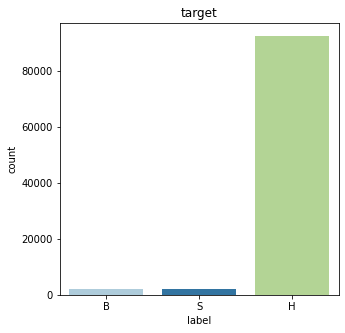

In [7]:
print(y.value_counts())
plt.figure(figsize=(5, 5))
axl = sns.countplot(y)
axl.set_title("target")

In [8]:
print('Holding:', round(y.value_counts()['H']/len(y),4))
print('Buy:', round(y.value_counts()['B']/len(y),4))
print('Sell:', round(y.value_counts()['S']/len(y),4))

Holding: 0.9551
Buy: 0.0225
Sell: 0.0225


In [9]:
pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 6.8 MB/s 


In [10]:
from keras import models
from keras import layers
from keras import optimizers
from keras.callbacks import Callback,ModelCheckpoint,ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Dropout
import keras.backend as K
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
import tensorflow_addons as tfa

In [11]:
# test 기간 10월 1일 ~ 12월 9일
onehot_encoder = OneHotEncoder()
y_onehot = onehot_encoder.fit_transform(y.values.reshape(-1, 1)).toarray()
X_test = X[78586:]
y_test = y_onehot[78586:]
X_data = X[:78586]
y_data = y_onehot[:78586]
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, shuffle=True,
                                                      stratify=y_data, random_state=12)

In [13]:
X_train

,ma_w,macd_w,macdsignal_w,macdhist_w,rsi_w,ad_w
24597,12.200000,6.698147,6.332111,0.366036,1.320197,4081.215789
22630,2.293333,-10.087122,-3.397035,-6.690088,-11.309699,-2331.369761
14738,-13.830000,-2.690497,-2.569892,-0.120605,3.882245,-8472.948522
50498,-33.816667,-9.113199,-6.859064,-2.254136,-2.187252,49286.320000
21166,2.953333,-8.038478,-2.893477,-5.145001,-7.889032,-14234.133333
...,...,...,...,...,...,...
69815,-9.383333,2.328874,1.505066,0.823808,3.297338,3015.000000
46214,-3.566667,4.536408,3.234773,1.301635,-3.286072,-8043.066667
51354,12.936667,-1.640134,7.595263,-9.235396,-16.883311,-12450.397143
70608,2.800000,-2.081730,-2.582127,0.500397,3.076279,3603.833333


In [14]:
y_train

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.]])

In [15]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dropout(rate=0.2))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

In [16]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
model.compile(optimizer=optimizers.Adagrad(lr=0.01),
              loss=tfa.losses.SigmoidFocalCrossEntropy(),
              metrics=[tfa.metrics.F1Score(3)])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adagrad.py:77: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adagrad, self).__init__(name, **kwargs)


In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                448       
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 3)                 99        
                                                                 
Total params: 2,627
Trainable params: 2,627
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train,
                    y_train,
                    epochs=100,
                    batch_size=32,
                    callbacks=[reduce_lr],
                    validation_data=(X_val, y_val))

Epoch 1/100
1965/1965 [==============================] - 6s 3ms/step - loss: 1.3622 - f1_score: 0.3304 - val_loss: 0.6466 - val_f1_score: 0.3261 - lr: 0.0100
Epoch 2/100
1965/1965 [==============================] - 5s 2ms/step - loss: 0.6507 - f1_score: 0.3261 - val_loss: 0.6466 - val_f1_score: 0.3261 - lr: 0.0100
Epoch 3/100
1965/1965 [==============================] - 5s 2ms/step - loss: 0.6504 - f1_score: 0.3261 - val_loss: 0.6466 - val_f1_score: 0.3261 - lr: 0.0100
Epoch 4/100
1965/1965 [==============================] - 5s 2ms/step - loss: 0.6503 - f1_score: 0.3261 - val_loss: 0.6466 - val_f1_score: 0.3261 - lr: 0.0100
Epoch 5/100
1965/1965 [==============================] - 5s 2ms/step - loss: 0.6504 - f1_score: 0.3261 - val_loss: 0.6466 - val_f1_score: 0.3261 - lr: 0.0100
Epoch 6/100
1965/1965 [==============================] - 5s 3ms/step - loss: 0.6502 - f1_score: 0.3261 - val_loss: 0.6466 - val_f1_score: 0.3261 - lr: 0.0100
Epoch 7/100
1965/1965 [=============================

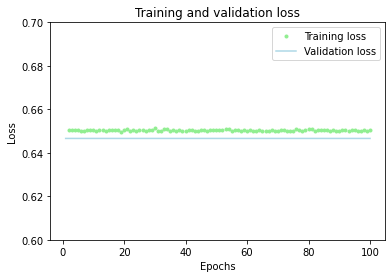

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.ylim([0.6, 0.7])
plt.plot(epochs, loss, '.', label='Training loss', color='lightgreen')
plt.plot(epochs, val_loss, '-', label='Validation loss', color='lightblue')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

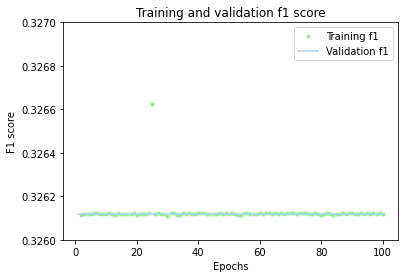

In [ ]:
plt.clf()

f1 = list(map(np.mean,history.history['f1_score']))
val_f1 = list(map(np.mean,history.history['val_f1_score'])) 

plt.ylim([0.326, 0.327])
plt.plot(epochs, f1, '.', label='Training f1', color='lightgreen')
plt.plot(epochs, val_f1, '-', label='Validation f1', color='lightblue')
plt.title('Training and validation f1 score')
plt.xlabel('Epochs')
plt.ylabel('F1 score')
plt.legend()

plt.show()

In [ ]:
y_pred = pd.DataFrame(model.predict(X_test)).round(0)

573/573 [==============================] - 1s 2ms/step


In [ ]:
# accuracy
1-len(y_pred.compare(pd.DataFrame(y_test)))/len(y_pred)

0.9439869102808836

In [ ]:
pip install git+https://github.com/microsoft/FLAML.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/microsoft/FLAML.git to /tmp/pip-req-build-75pa_2ap
  Running command git clone -q https://github.com/microsoft/FLAML.git /tmp/pip-req-build-75pa_2ap
  Created wheel for FLAML: filename=FLAML-1.1.0-py3-none-any.whl size=219759 sha256=2bf0327140a29f8032178f9285fb8a41be039392bd1a9ba62813873e087db2ce
  Stored in directory: /tmp/pip-ephem-wheel-cache-8i7e7b92/wheels/5c/1a/48/c07dfe482b630f96d7258700d361a971759465895f9dd768ee
Successfully built FLAML
  Attempting uninstall: FLAML
    Found existing installation: FLAML 1.0.14
    Uninstalling FLAML-1.0.14:
      Successfully uninstalled FLAML-1.0.14


In [18]:
X_test = X[78586:]
y_test = y[78586:]
X_data = X[:78586]
y_data = y[:78586]
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, shuffle=True,
                                                      stratify=y_data, random_state=12)

In [19]:
X_train

,ma_w,macd_w,macdsignal_w,macdhist_w,rsi_w,ad_w
24597,12.200000,6.698147,6.332111,0.366036,1.320197,4081.215789
22630,2.293333,-10.087122,-3.397035,-6.690088,-11.309699,-2331.369761
14738,-13.830000,-2.690497,-2.569892,-0.120605,3.882245,-8472.948522
50497,-34.236667,-10.165815,-6.295530,-3.870285,-2.723221,51012.290000
21166,2.953333,-8.038478,-2.893477,-5.145001,-7.889032,-14234.133333
...,...,...,...,...,...,...
69815,-9.383333,2.328874,1.505066,0.823808,3.297338,3015.000000
46214,-3.566667,4.536408,3.234773,1.301635,-3.286072,-8043.066667
51354,12.936667,-1.640134,7.595263,-9.235396,-16.883311,-12450.397143
70839,20.283333,-5.939089,-5.549629,-0.389460,-0.074745,42065.650000


In [20]:
y_train

24597    H
22630    H
14738    H
50497    B
21166    H
        ..
69815    H
46214    H
51354    H
70839    S
15024    H
Name: label, Length: 62868, dtype: object

In [ ]:
from flaml import AutoML
automl = AutoML()

automl.fit(X_train, y_train,
           task='classification',
           X_val=X_val, y_val=y_val,
           time_budget=60*10,
           log_file_name='.automl.log',
           estimator_list=['lgbm'])

[flaml.automl: 12-11 13:12:14] {2599} INFO - task = classification
INFO:flaml.automl:task = classification
[flaml.automl: 12-11 13:12:14] {2601} INFO - Data split method: stratified
INFO:flaml.automl:Data split method: stratified
[flaml.automl: 12-11 13:12:14] {2604} INFO - Evaluation method: holdout
INFO:flaml.automl:Evaluation method: holdout
[flaml.automl: 12-11 13:12:14] {2726} INFO - Minimizing error metric: log_loss
INFO:flaml.automl:Minimizing error metric: log_loss
[flaml.automl: 12-11 13:12:14] {2870} INFO - List of ML learners in AutoML Run: ['lgbm']
INFO:flaml.automl:List of ML learners in AutoML Run: ['lgbm']
[flaml.automl: 12-11 13:12:14] {3166} INFO - iteration 0, current learner lgbm
INFO:flaml.automl:iteration 0, current learner lgbm
[flaml.automl: 12-11 13:12:14] {3296} INFO - Estimated sufficient time budget=7263s. Estimated necessary time budget=7s.
INFO:flaml.automl:Estimated sufficient time budget=7263s. Estimated necessary time budget=7s.
[flaml.automl: 12-11 13:1

In [ ]:
import pickle
with open('.automl.pkl', 'wb') as f:
    pickle.dump(automl, f, pickle.HIGHEST_PROTOCOL)
with open('.automl.pkl', 'rb') as f:
    automl = pickle.load(f)

In [ ]:
print('Best ML leaner:', automl.best_estimator)
print('Best hyperparmeter config:', automl.best_config)
print('Best loss on validation data: {0:.4g}'.format(automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))

Best ML leaner: lgbm
Best hyperparmeter config: {'n_estimators': 124, 'num_leaves': 34, 'min_child_samples': 14, 'learning_rate': 0.023685869156657772, 'log_max_bin': 9, 'colsample_bytree': 0.9930690838565842, 'reg_alpha': 0.0014141288873710895, 'reg_lambda': 1.9806480337540229, 'FLAML_sample_size': 62868}
Best loss on validation data: 0.1654
Training duration of best run: 2.831 s


In [ ]:
y_pred = automl.predict(X_test)
print('Predicted labels', y_pred)
print('True labels', y_test)
y_pred_proba = automl.predict_proba(X_test)[:,1]

Predicted labels ['H' 'H' 'H' ... 'H' 'H' 'H']
True labels 78631    B
78632    H
78633    H
78634    H
78635    H
        ..
96961    H
96962    H
96963    H
96964    H
96965    H
Name: label, Length: 18335, dtype: object


In [ ]:
pd.Series(y_pred).unique()

array(['H', 'S', 'B'], dtype=object)

In [ ]:
''' compute different metric values on testing dataset'''
from flaml.ml import sklearn_metric_loss_score
print('accuracy', '=', 1 - sklearn_metric_loss_score('accuracy', y_pred, y_test))

accuracy = 0.9435505863103354


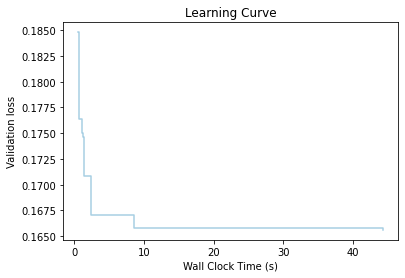

In [ ]:
from flaml.data import get_output_from_log
import matplotlib.pyplot as plt
import numpy as np

time_history, best_valid_loss_history, valid_loss_history, config_history, metric_history = \
    get_output_from_log(filename='.automl.log', time_budget=60)

plt.title("Learning Curve")
plt.xlabel("Wall Clock Time (s)")
plt.ylabel("Validation loss")
plt.step(time_history, np.array(best_valid_loss_history), where="post")
plt.show()

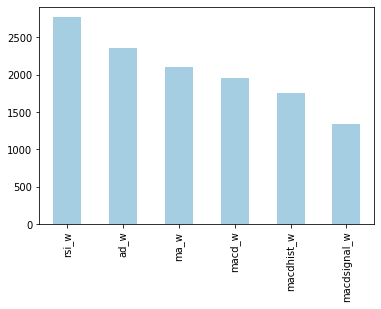

In [ ]:
pd.Series(automl.feature_importances_, index=automl.feature_names_in_).sort_values(ascending=False).plot.bar()

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
report = classification_report(y_test, y_pred)

In [ ]:
print(report)

              precision    recall  f1-score   support

           B       0.09      0.00      0.00       512
           H       0.94      1.00      0.97     17311
           S       0.14      0.00      0.00       512

    accuracy                           0.94     18335
   macro avg       0.39      0.33      0.33     18335
weighted avg       0.90      0.94      0.92     18335



In [ ]:
pd.Series(y_pred, index=y_test.index).astype('category').to_pickle('.y_pred.pkl')